1. 데이터셋 불러오기

In [55]:
# pip install torchvision
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
# FashionMNIST 데이터셋 불러오기

# torchvision.transforms.Compose를 사용하여 이미지 변환을 연결하는데, 여기서는 이미지를 Tensor로 변환합니다.
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

# FashionMNIST 학습 데이터셋을 불러와서 trainset 변수에 저장합니다.
# root는 데이터셋이 저장될 디렉토리를 지정하고, train은 학습 데이터셋을 의미합니다.
# download=True로 설정하여 데이터셋을 인터넷에서 다운로드합니다.
# transform 매개변수에 위에서 정의한 이미지 변환을 적용합니다.
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# FashionMNIST 테스트 데이터셋을 불러와서 testset 변수에 저장합니다.
# train=False로 설정하여 테스트 데이터셋을 불러옵니다.
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader 생성
batch_size = 64
# trainloader는 학습 데이터셋을 미니배치로 제공하는 DataLoader입니다.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
# testloader는 테스트 데이터셋을 미니배치로 제공하는 DataLoader입니다.
# shuffle=False로 설정하여 테스트 데이터셋을 섞지 않습니다.
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# 클래스 레이블을 정의합니다.
# FashionMNIST의 클래스는 다음과 같은 순서로 정의됩니다: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
# 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 데이터셋 크기를 확인하여 학습 데이터셋과 테스트 데이터셋의 크기를 출력합니다.
print("학습 데이터셋 크기:", len(trainset))
print("테스트 데이터셋 크기:", len(testset))



학습 데이터셋 크기: 60000
테스트 데이터셋 크기: 10000


2. 이미지 시각화


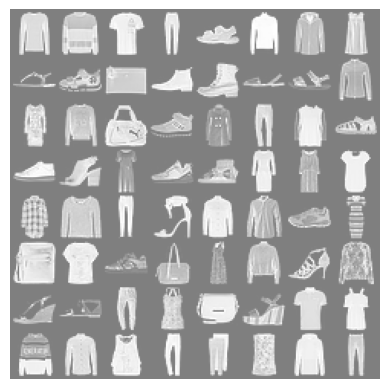

Pullover Pullover T-shirt/top Trouser


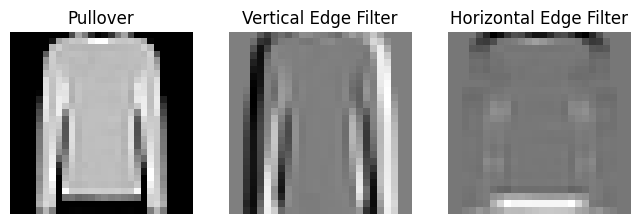

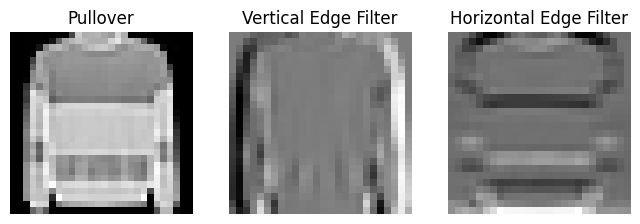

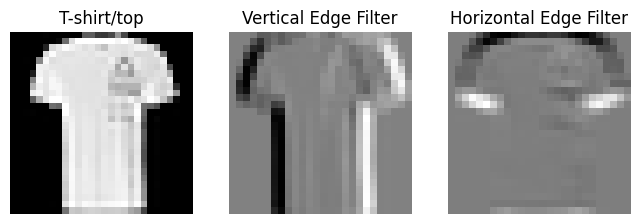

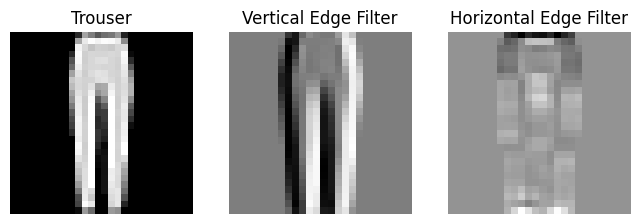

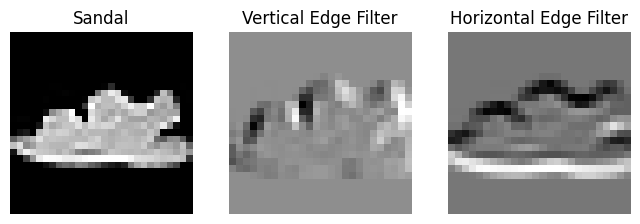

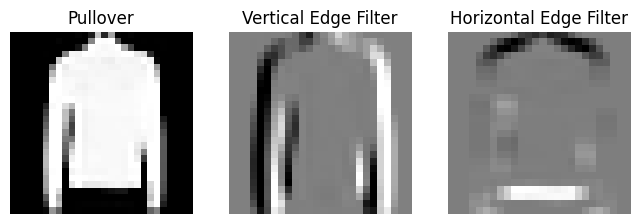

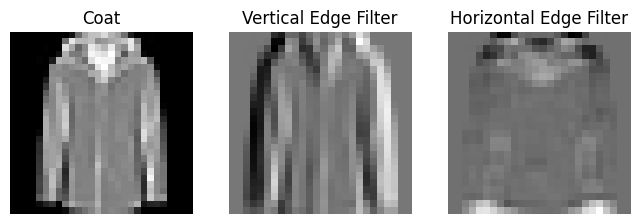

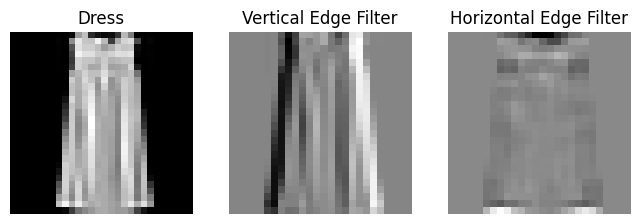

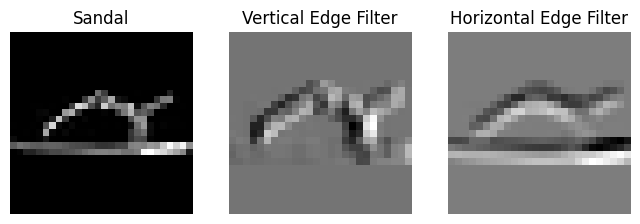

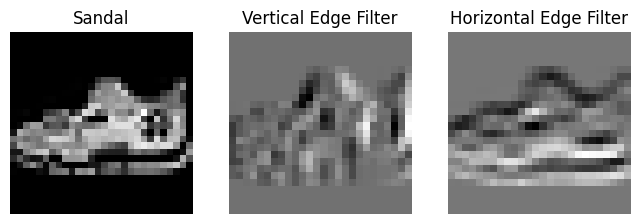

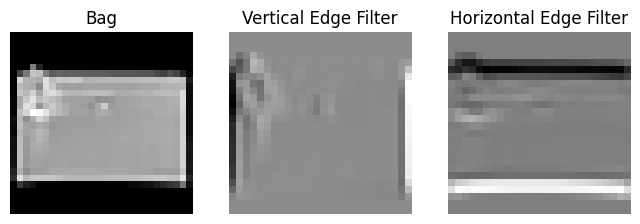

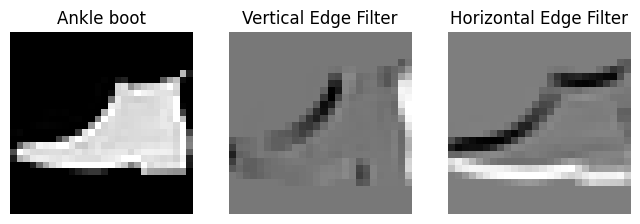

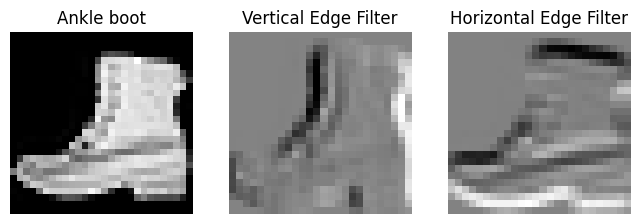

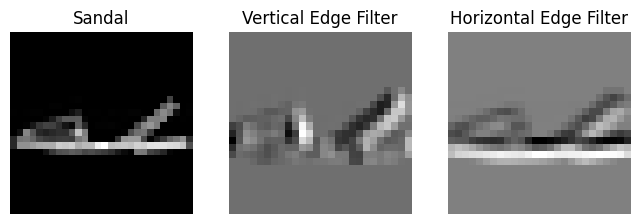

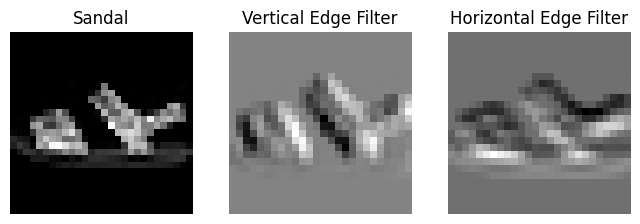

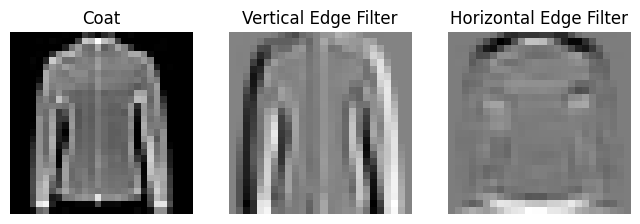

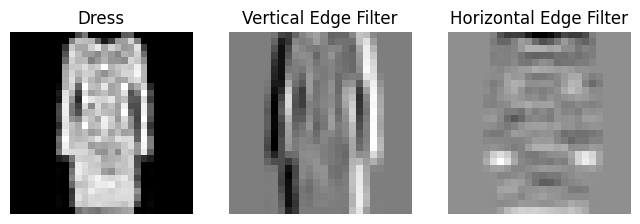

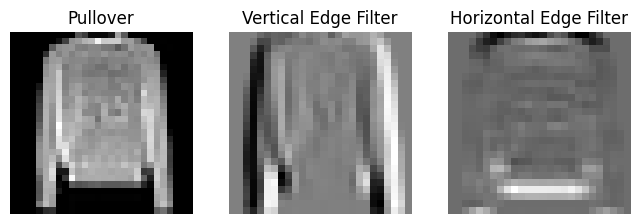

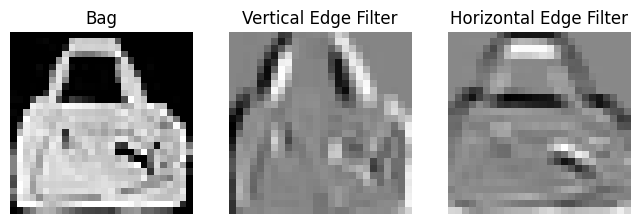

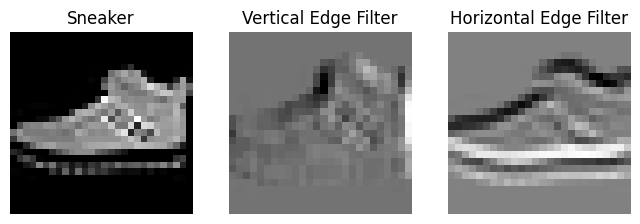

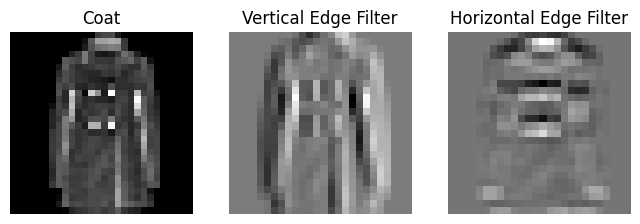

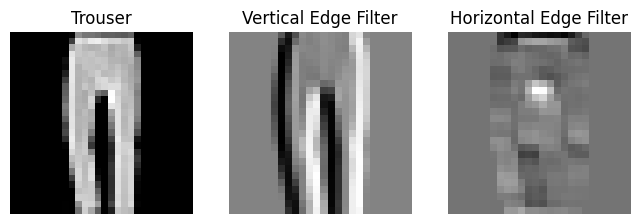

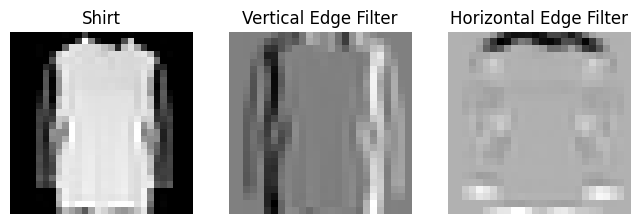

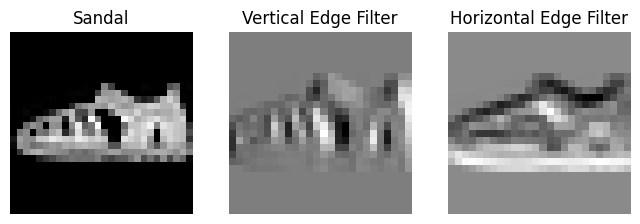

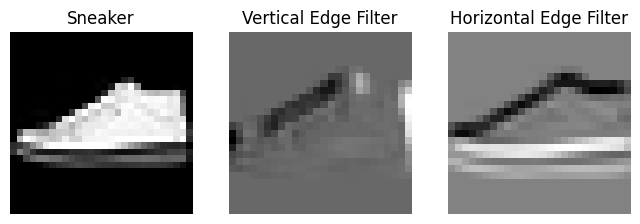

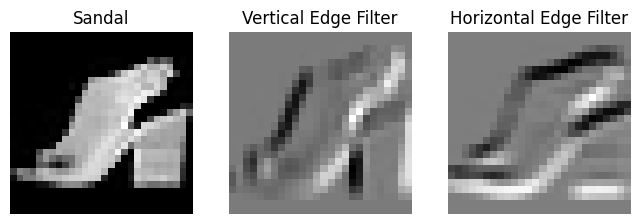

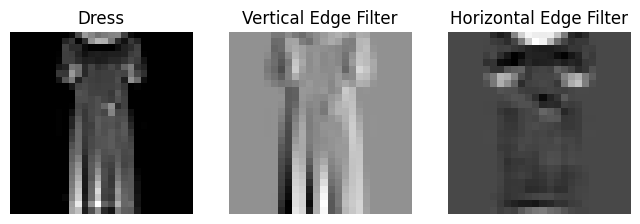

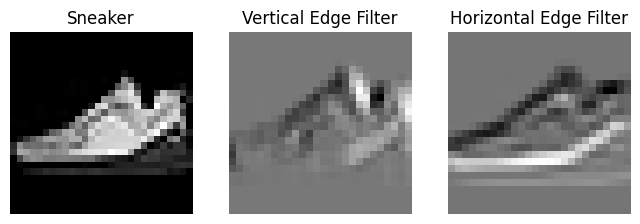

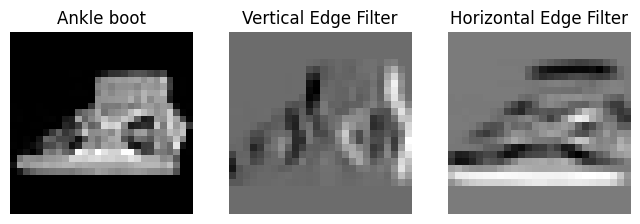

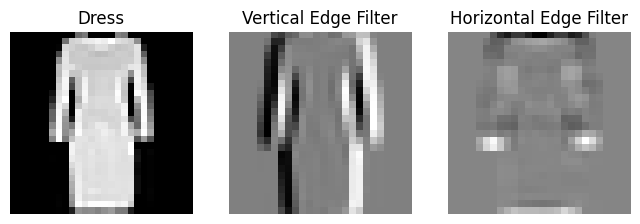

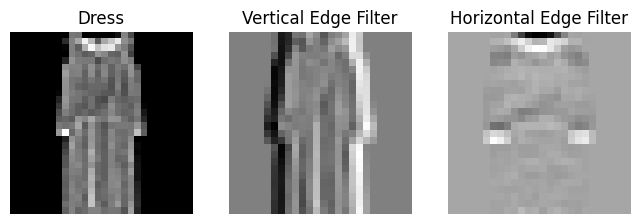

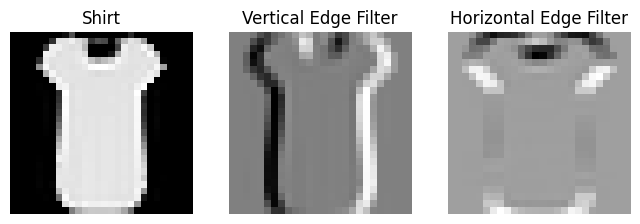

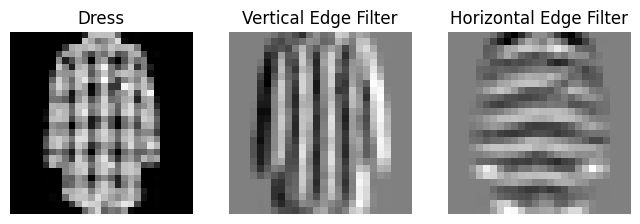

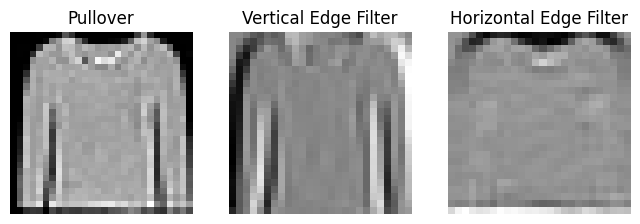

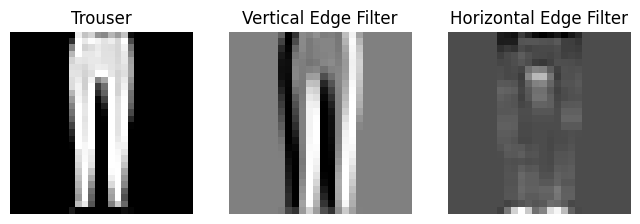

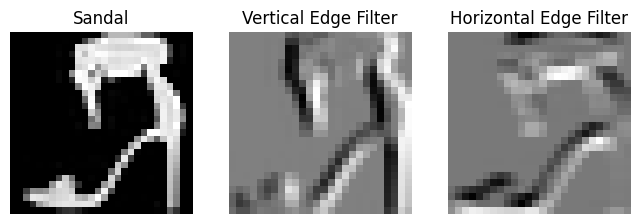

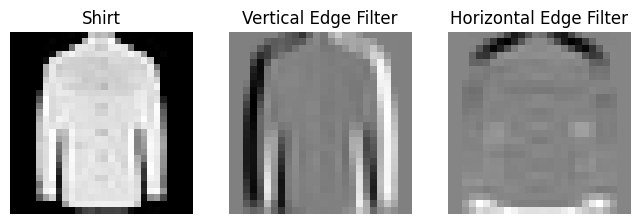

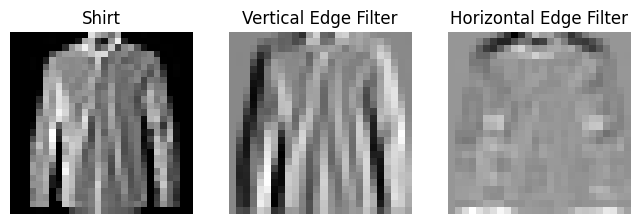

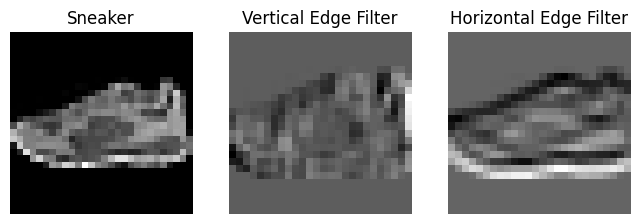

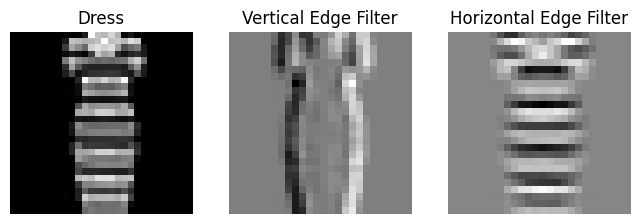

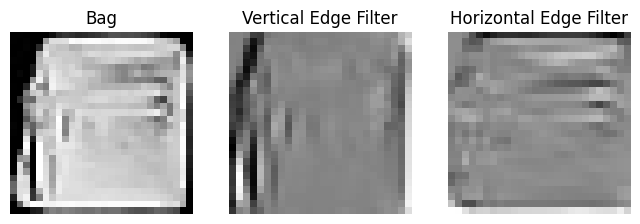

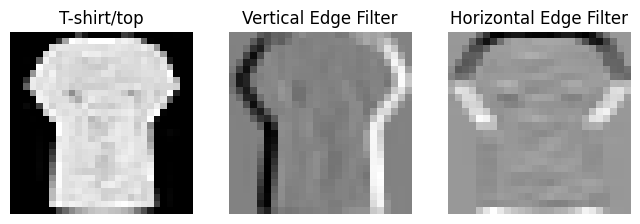

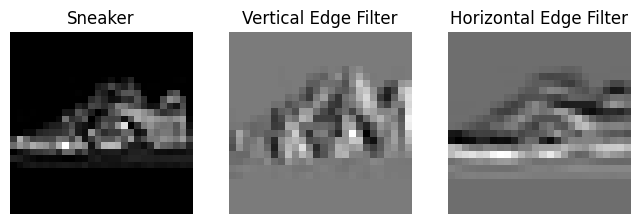

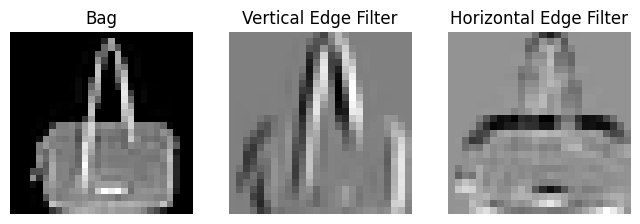

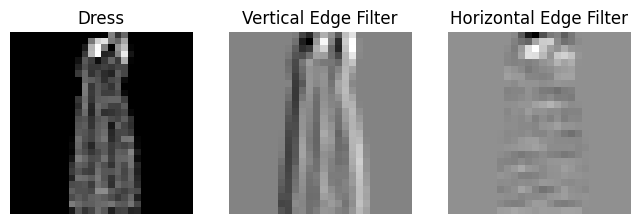

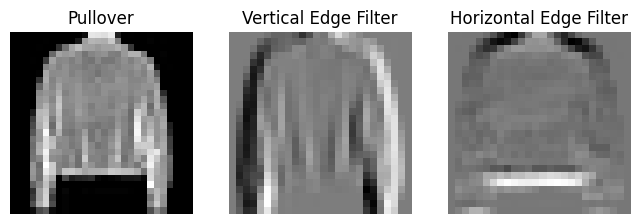

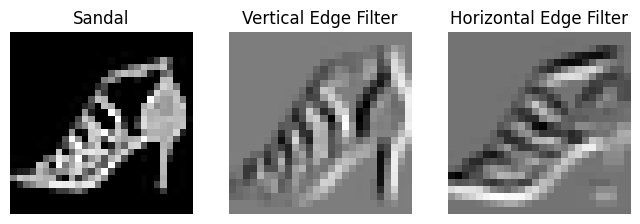

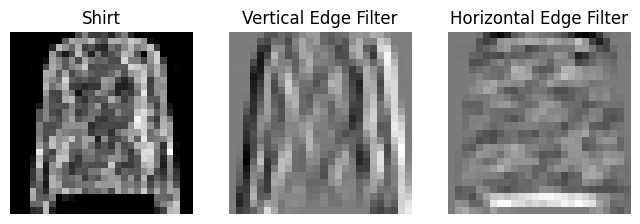

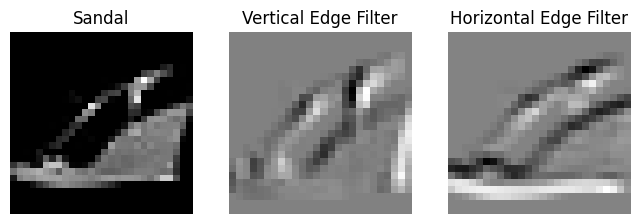

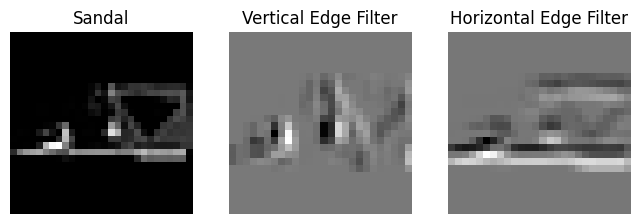

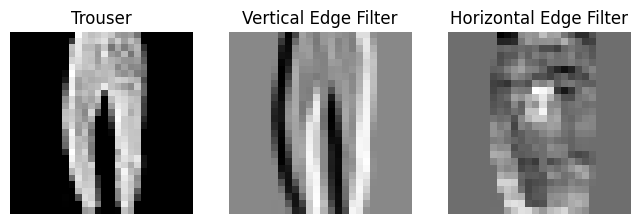

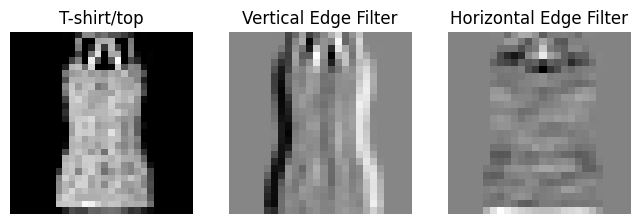

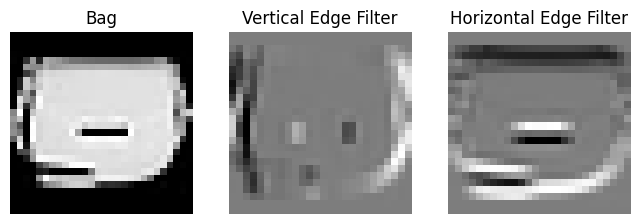

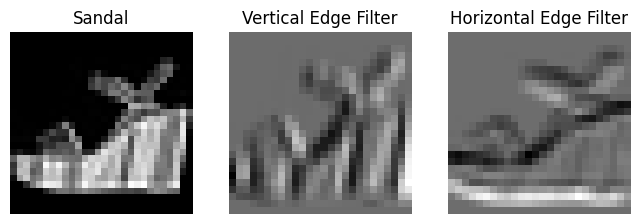

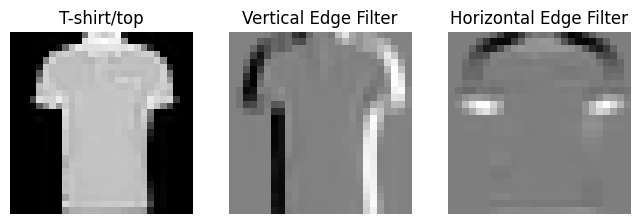

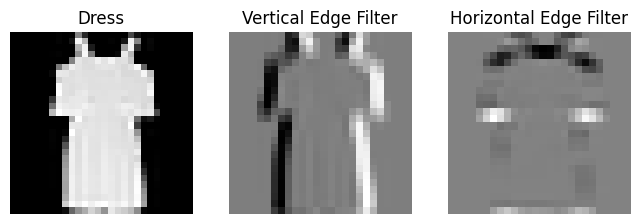

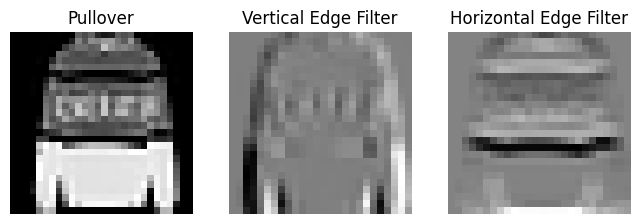

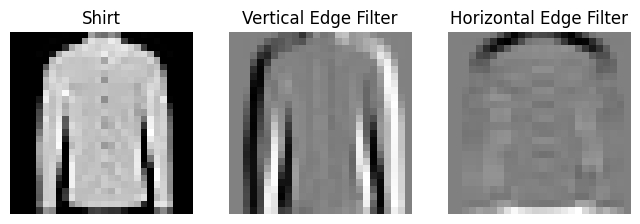

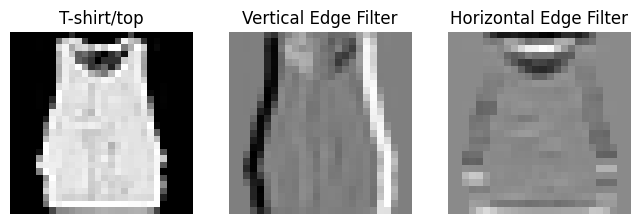

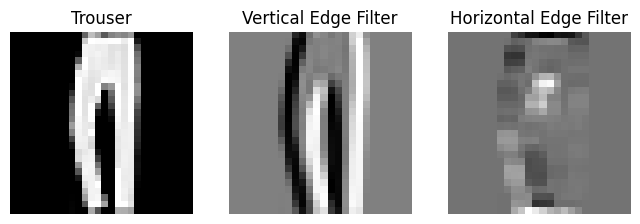

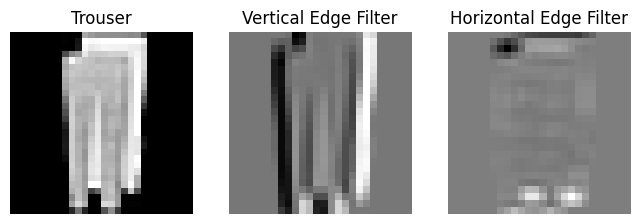

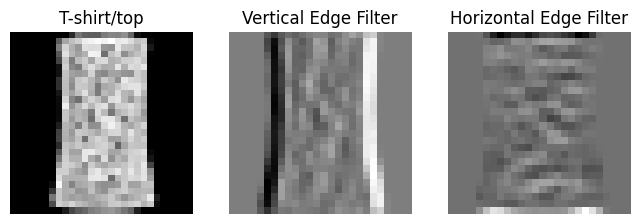

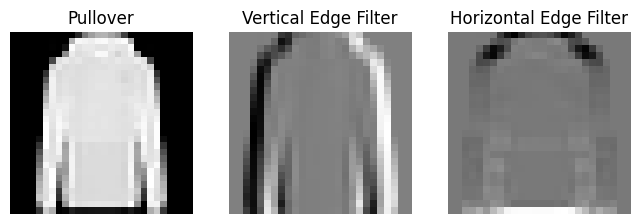

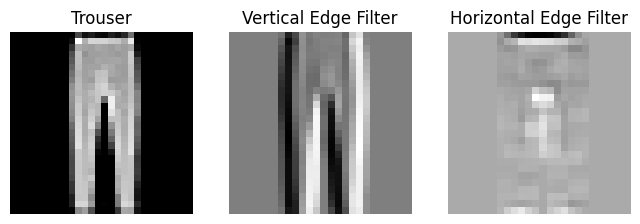

In [56]:
# 데이터셋에서 무작위로 이미지 가져와서 시각화하는 함수 정의
def imshow(img):
    # 이미지를 [-1,1] 범위에서 [0,1] 범위로 변경
    img = img / 2 + 0.5
    # 이미지를 NumPy 배열로 변환
    npimg = img.numpy()
    # 이미지를 시각화하기 위해 차원 순서 변경 (채널이 마지막 차원이 되도록)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # 축 숨기기
    plt.axis('off')
    # 이미지 출력
    plt.show()

# 학습 데이터를 가져와서 이미지와 해당 클래스 레이블 출력
dataiter = iter(trainloader)
images, labels = next(dataiter)
# 이미지 그리드 생성 및 출력
imshow(torchvision.utils.make_grid(images))
# 이미지에 해당하는 클래스 레이블 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 필터 정의
vertical_edge_filter = torch.Tensor([[1, 0, -1],
                                     [1, 0, -1],
                                     [1, 0, -1]])
horizontal_edge_filter = torch.Tensor([[1, 1, 1],
                                       [0, 0, 0],
                                       [-1, -1, -1]])

# 이미지에 수직 에지 필터 적용
vertical_edge_filtered_image = F.conv2d(images, vertical_edge_filter.unsqueeze(0).unsqueeze(0))
# 이미지에 수평 에지 필터 적용
horizontal_edge_filtered_image = F.conv2d(images, horizontal_edge_filter.unsqueeze(0).unsqueeze(0))

# 이미지와 필터 결과 시각화
for i in range(len(images)):
    # 이미지 및 필터 결과를 담을 Figure 생성
    plt.figure(figsize=(8, 4))
    
    # 원본 이미지 출력
    plt.subplot(1, 3, 1)
    plt.imshow(images[i][0], cmap='gray')  # 이미지 출력
    plt.axis('off')  # 축 숨기기
    plt.title(classes[labels[i]])  # 이미지에 해당하는 클래스 레이블 출력

    # 수직 에지 필터 결과 출력
    plt.subplot(1, 3, 2)
    plt.imshow(vertical_edge_filtered_image[i][0].detach().numpy(), cmap='gray')  # 이미지 출력
    plt.axis('off')  # 축 숨기기
    plt.title('Vertical Edge Filter')  # 제목 출력

    # 수평 에지 필터 결과 출력
    plt.subplot(1, 3, 3)
    plt.imshow(horizontal_edge_filtered_image[i][0].detach().numpy(), cmap='gray')  # 이미지 출력
    plt.axis('off')  # 축 숨기기
    plt.title('Horizontal Edge Filter')  # 제목 출력

    # 이미지 및 필터 결과 출력
    plt.show()


3. 간단한 CNN 모델을 구축

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

# 데이터셋 정의 (예시로 torchvision의 FashionMNIST 데이터셋 사용)
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 데이터로더 정의
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# 신경망 모델 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(6 * 12 * 12, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 6 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 모델 생성
net = Net()

4. 모델을 컴파일하고, 적절한 손실 함수와 최적화 알고리즘을 선택합니다.

In [75]:
import torch.optim as optim

# 교차 엔트로피 손실 함수를 정의합니다.
criterion = nn.CrossEntropyLoss()

# SGD 최적화 알고리즘을 사용하여 모델의 매개변수를 최적화합니다.
# lr은 학습률(learning rate)로, 모델의 가중치를 업데이트할 때 사용되는 스케일링 요소입니다.
# momentum은 관성을 의미하며, SGD의 업데이트에 이전 단계의 업데이트 방향을 고려하는 데 사용됩니다.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


5. 훈련 데이터를 사용하여 모델을 훈련, 손실과 정확도를 모니터링

In [76]:
# DataLoader 생성
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
# 에폭 반복
epochs = 5  # 에폭을 5으로 수정
train_losses = []  # 훈련 손실 저장용 리스트
test_losses = []   # 테스트 손실 저장용 리스트
train_accuracy = []  # 훈련 정확도 저장용 리스트
test_accuracy = []   # 테스트 정확도 저장용 리스트

for epoch in range(epochs):
    running_loss = 0.0  # 훈련 손실 초기화
    correct_train = 0    # 훈련 정확도 초기화
    total_train = 0      # 훈련 데이터 총 개수 초기화
    
    # 훈련 단계
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # 정확도 계산
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # 에폭마다 훈련 손실 및 정확도 기록
    train_losses.append(running_loss / len(trainloader))
    train_accuracy.append(100 * correct_train / total_train)

    # 훈련 손실 및 정확도 출력
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy[-1]:.2f}%')

    # 테스트 단계
    net.eval()  # 모델을 평가 모드로 설정
    test_loss = 0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # 에폭마다 테스트 손실 및 정확도 기록
    test_losses.append(test_loss / len(testloader))
    test_accuracy.append(100 * correct_test / total_test)

    # 테스트 손실 및 정확도 출력
    print(f'Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracy[-1]:.2f}%')

    # 모델을 다시 훈련 모드로 변경
    net.train()


Epoch [1/5], Train Loss: 1.1887, Train Accuracy: 59.88%
Test Loss: 0.6334, Test Accuracy: 75.45%
Epoch [2/5], Train Loss: 0.5480, Train Accuracy: 79.64%
Test Loss: 0.5191, Test Accuracy: 80.61%
Epoch [3/5], Train Loss: 0.4716, Train Accuracy: 82.86%
Test Loss: 0.4770, Test Accuracy: 82.32%
Epoch [4/5], Train Loss: 0.4308, Train Accuracy: 84.56%
Test Loss: 0.4450, Test Accuracy: 83.78%
Epoch [5/5], Train Loss: 0.4045, Train Accuracy: 85.45%
Test Loss: 0.4176, Test Accuracy: 85.12%


6. 학습결과 그래프

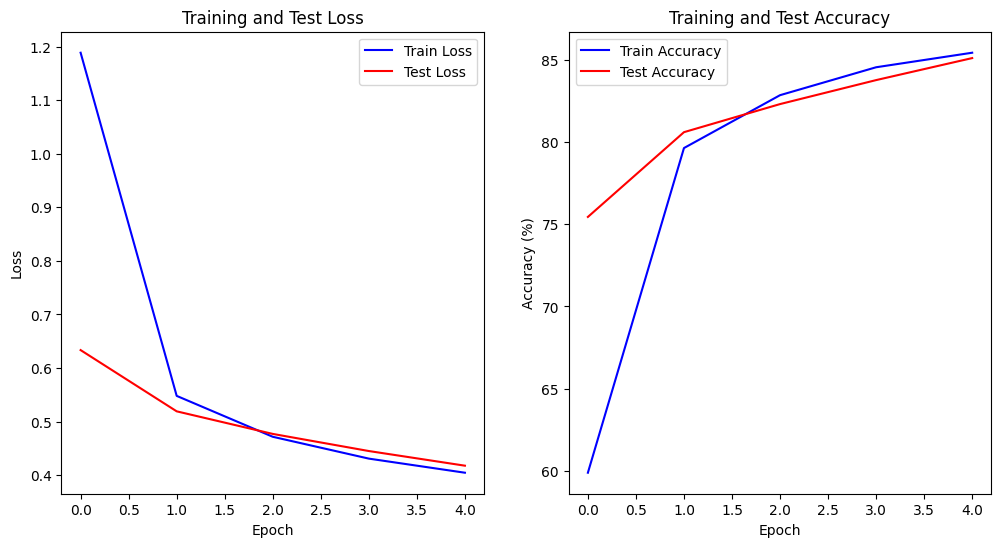

In [77]:
import matplotlib.pyplot as plt

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy', color='blue')
plt.plot(test_accuracy, label='Test Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.show()


7. 테스트 데이터셋을 사용하여 모델을 평가하고, 최종 정확도를 보고한다

In [67]:
# 모델 평가
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('테스트 데이터셋 정확도: %d %%' % (100 * correct / total))

테스트 데이터셋 정확도: 86 %


8. 잘못 분류된 이미지들을 분석하고, 어떤 클래스가 모델에 의해 가장 잘못 분류되었는지를 식별합니다.

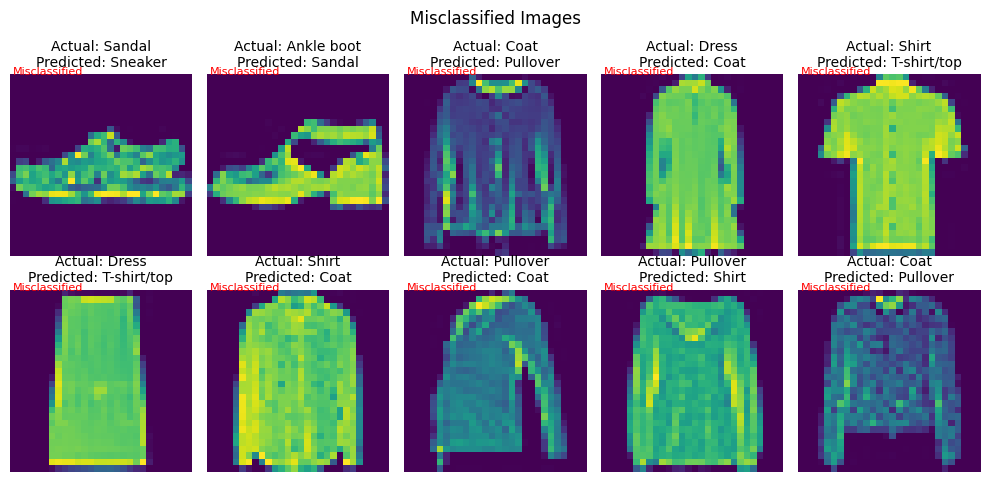

In [68]:
# 잘못 분류된 이미지 및 레이블 저장용 리스트
misclassified_images = []
correct_labels = []
predicted_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(predicted)):
            if predicted[i] != labels[i]:
                misclassified_images.append(images[i])
                correct_labels.append(labels[i].item())
                predicted_labels.append(predicted[i].item())

# 잘못 분류된 이미지 시각화 및 분석
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle('Misclassified Images')

for i in range(min(len(misclassified_images), 10)):  # 최대 10개의 이미지만 표시
    # 이미지의 차원 확인 및 변환
    mis_img = misclassified_images[i].squeeze()  # 이미지 차원 축소
    if len(mis_img.shape) == 2:  # 2차원 이미지인 경우 (C, H, W) 형태로 변경
        mis_img = mis_img.unsqueeze(0)
    mis_img = mis_img.permute(1, 2, 0)  # 이미지 차원 순서 변경 (H, W, C)
    mis_img = mis_img / 2 + 0.5  # 이미지를 [0,1] 범위로 변환

    # 이미지 시각화
    axs[i // 5, i % 5].imshow(mis_img)  # 이미지 표시
    axs[i // 5, i % 5].axis('off')  # 축 제거

    # 실제 클래스 레이블과 예측된 클래스 레이블 출력
    actual_class = classes[correct_labels[i]]
    predicted_class = classes[predicted_labels[i]]
    axs[i // 5, i % 5].set_title(f'Actual: {actual_class}\nPredicted: {predicted_class}', fontsize=10)  # 텍스트 크기 조정
    
    # 잘못된 분류 여부 확인 및 표시
    classification_text = 'Misclassified' if actual_class != predicted_class else 'Correctly Classified'
    text_color = 'red' if actual_class != predicted_class else 'green'
    axs[i // 5, i % 5].text(0, -0.5, classification_text, color=text_color, fontsize=8, ha='left')  # 텍스트 추가

plt.tight_layout()  # 레이아웃 조정
plt.show()